In this notebook I perform a hyperparameter tuning on a CNN trained with the Fashion MNIST dataset. Instead of using Hyperopt, Random Search or Grid Search as in the MNIST notebook, in this case I chose Optuna as hyperparameter optimization framework.

Import necessary packages

In [36]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf 
from tensorflow import keras
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold

# 1. Reading the data
We start by reading and saving the train and test datasets, directly from the keras package:

In [37]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

During all the notebook, we will use only the train dataset, as the test set is used only at the end, when evaluating the final/tuned model.

The shapes of the sets are:

In [38]:
X_train_full.shape, y_train_full.shape,  X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

# 2. Preparing the data

Due the large amount of data available, we select the first 5000 instances to speed up the process. We also select the last 5000 instances of the train set as validation data for the Neural Network:

In [39]:
X_train, X_valid = X_train_full[:5000] / 255.0, X_train_full[55000:] / 255.0
y_train, y_valid = y_train_full[:5000] , y_train_full[55000:]

In [40]:
X_train.shape, X_valid.shape

((5000, 28, 28), (5000, 28, 28))

And we can plot one of the instances:

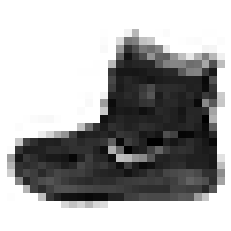

In [41]:
plt.imshow(X_train[0].reshape(28,28), cmap='binary')
plt.axis('off')
plt.show()

This dataset is more complex than MNIST, so we can expect to obtain lower accuracies using the same approaches.

# 3. Implementing a Neural Network

As the images are in grayscale (single color channel), we must reshape them in this way: (N, height, size, 1). If the images were in RGB, the last number of the reshape sould be 3.

In [42]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

Convolutional Neural Networks (CNNs) can achieve an awesome performance in complex tasks as image recognition, so they are the perfect choice for these type of tasks/problems.
We will use Optuna for the hyperparameter optimization.

## Optuna
The first hyperparameter to tune is the optimizer used during the model compilation. We pass 'Adam' and 'SGD' as options, each one with its learning rate (another hyperparameter) and, in the case of SGD, a momentum(also an hyperparameter).

In [43]:
import optuna
def create_optimizer(trial):
    optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "SGD"])
    if optimizer_name == "Adam":
        adam_lr = trial.suggest_loguniform("adam_lr", 1e-5, 1e-1)
        optimizer = keras.optimizers.Adam(learning_rate=adam_lr)
    else:
        sgd_lr = trial.suggest_loguniform("sgd_lr", 1e-5, 1e-1)
        sgd_momentum = trial.suggest_loguniform("sgd_momentum", 1e-5, 1e-1)
        optimizer = keras.optimizers.SGD(learning_rate=sgd_lr, momentum=sgd_momentum)
    return optimizer

Next, we define the model in a function. It's a Sequential model, and we will tune the number of Conv2D and MaxPooling2D layers, in blocks, using a for loop. Also, the dropout rate used in the Dropout layers will be tuned.

In [44]:
def build_model(n_blocks, dropout_rate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(2))
    for layer in range(1,n_blocks):
        model.add(keras.layers.Conv2D(128 * layer ,3,activation='relu', padding='same'))
        model.add(keras.layers.Conv2D(128 * layer ,3,activation='relu', padding='same'))
        model.add(keras.layers.MaxPooling2D(2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

Finally, we define the function to minimize, including some parameters for the fit process and the hyperparameters: the number of blocks in the CNN, the dropout rate and the optimizer.

In [45]:
def objective(trial):
    # parameters for fitting the model
    batch_size = 32
    n_epochs = 20
    # Defining the hyperparameter space
    n_blocks = trial.suggest_int('n_blocks', 1, 4)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    # Set the optimizer
    optimizer =create_optimizer(trial)
    # Build, compile and fit the model
    model = build_model(n_blocks, dropout_rate)
    # compile the model using the optimizer
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # fit the model using validation data
    history = model.fit(X_train, y_train, epochs=n_epochs, verbose=0, batch_size=batch_size, validation_data=(X_valid, y_valid))
    # return 1-val_accuracy
    return 1 - history.history['val_accuracy'][-1]

And now, the process of optimization begins, during a number of trials defined in n_trials.

In [46]:
study = optuna.create_study()
start_time = time.time()
study.optimize(objective, n_trials=50)

[I 2020-04-20 09:36:10,961] Finished trial#0 with value: 0.15619999170303345 with parameters: {'n_blocks': 3, 'dropout_rate': 0.27372050364126566, 'optimizer_name': 'SGD', 'sgd_lr': 0.03049963284655515, 'sgd_momentum': 0.016413531514489783}. Best is trial#0 with value: 0.15619999170303345.
[I 2020-04-20 09:38:21,881] Finished trial#1 with value: 0.15420001745224 with parameters: {'n_blocks': 2, 'dropout_rate': 0.20674187887787226, 'optimizer_name': 'Adam', 'adam_lr': 0.008793440959350701}. Best is trial#1 with value: 0.15420001745224.
[I 2020-04-20 09:39:06,406] Finished trial#2 with value: 0.1615999937057495 with parameters: {'n_blocks': 1, 'dropout_rate': 0.18516409167603987, 'optimizer_name': 'Adam', 'adam_lr': 3.6412598620922556e-05}. Best is trial#1 with value: 0.15420001745224.
[I 2020-04-20 09:42:09,565] Finished trial#3 with value: 0.20260000228881836 with parameters: {'n_blocks': 3, 'dropout_rate': 0.09855691985286091, 'optimizer_name': 'Adam', 'adam_lr': 1.6807297326221457e-0

In [ ]:
print('Execution time:',time.time()- start_time)

Once finished, the best hyperparameters found can be accesed as:

In [54]:
study.best_params

{'n_blocks': 2,
 'dropout_rate': 0.14742155017391867,
 'optimizer_name': 'Adam',
 'adam_lr': 0.0004911876631472576}

and we can use them to create a new model that performs the best in the dataset:

In [48]:
conv_blocks = int(study.best_params['n_blocks'])
dropout_rate = study.best_params['dropout_rate']
if study.best_params['optimizer_name'] == 'Adam':
    optimizer = optimizer = keras.optimizers.Adam(learning_rate=study.best_params['adam_lr'])
else:
    optimizer = keras.optimizers.SGD(learning_rate=study.best_params['sgd_lr'], momentum=study.best_params['sgd_momentum'])

Reducing the learning rate when a plateau is found is a useful technique to improve the model. It can be introduced in the CNN usign a keras callback:

In [49]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

The model is ready to compile and fit:

In [55]:
# define the model with the best hyperparameters
model = build_model(conv_blocks, dropout_rate)
n_epochs = 30
batch_size = 32
# review the model
model.summary()
# compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit the model, with validation data and the reduce_lr callback
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[reduce_lr])

0.0637 - accuracy: 0.972272/5000 [============>.................] - ETA: 0s - loss: 0.0663 - accuracy: 0.972464/5000 [=============>................] - ETA: 0s - loss: 0.0660 - accuracy: 0.972656/5000 [==============>...............] - ETA: 0s - loss: 0.0632 - accuracy: 0.972848/5000 [================>.............] - ETA: 0s - loss: 0.0647 - accuracy: 0.973040/5000 [=================>............] - ETA: 0s - loss: 0.0635 - accuracy: 0.973232/5000 [==================>...........] - ETA: 0s - loss: 0.0638 - accuracy: 0.973456/5000 [===================>..........] - ETA: 0s - loss: 0.0641 - accuracy: 0.973648/5000 [====================>.........] - ETA: 0s - loss: 0.0624 - accuracy: 0.973872/5000 [======================>.......] - ETA: 0s - loss: 0.0611 - accuracy: 0.974064/5000 [=======================>......] - ETA: 0s - loss: 0.0603 - accuracy: 0.974256/5000 [========================>.....] - ETA: 0s - loss: 0.0595 - accuracy: 0.974448/5000 [=========================>....] - ETA: 0s 

We can plot the evolution of accuracies and losses with training epochs:

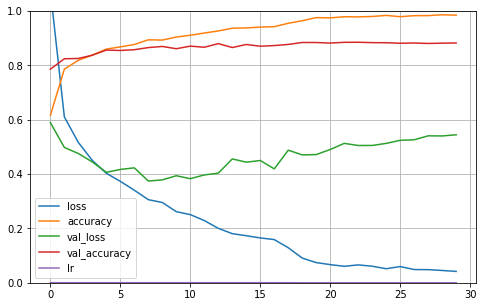

In [59]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

And finally, evaluate the CNN with the test set:

In [60]:
model.evaluate(X_test, y_test)

32/10000 [..............................] - ETA: 35s - loss: 338.3814 - accuracy: 0.781  288/10000 [..............................] - ETA: 5s - loss: 117.3089 - accuracy: 0.87  704/10000 [=>............................] - ETA: 2s - loss: 110.0589 - accuracy: 0.86 1152/10000 [==>...........................] - ETA: 2s - loss: 117.3985 - accuracy: 0.87 1600/10000 [===>..........................] - ETA: 1s - loss: 110.3156 - accuracy: 0.87 2048/10000 [=====>........................] - ETA: 1s - loss: 111.5188 - accuracy: 0.87 2496/10000 [======>.......................] - ETA: 1s - loss: 107.4503 - accuracy: 0.87 2944/10000 [=======>......................] - ETA: 1s - loss: 111.3919 - accuracy: 0.87 3392/10000 [=========>....................] - ETA: 1s - loss: 113.3695 - accuracy: 0.86 3680/10000 [==========>...................] - ETA: 1s - loss: 113.6461 - accuracy: 0.86 4032/10000 [===========>..................] - ETA: 0s - loss: 113.6179 - accuracy: 0.86 4352/10000 [============>.......

[110.16916485900879, 0.8665]